#                           Game Console Sentiment Analysis
##                                            Rudy Duran
##                                             Practicum 1
##                                              4-08-2021

#                                         Purpose

The purpose of this project is to analyze Amazon consumer reviews to see what consumers think of the new game consoles: the<br> Playstation 5 and the Xbox Series X. The scope of this project will focus on the Playstation 5, Xbox Series X, and their<br> direct predecessors: The Playstation 4 and Xbox One X. The methods for this project include analyzing customer reviews for these products to see if there are different sentiments and what the different sentiments are between the PS5, Xbox Series X<br> and their respective predecessors.<br>This analysis will help in better undestanding consumers needs and areas for improvement with the new consoles.<br>

Natural Language Processing, LDA topic modeling, and sentiment analysis will be used on these reviews in order to achieve this purpose.

For context, LDA topic modeling is a popular topic modeling method which aims to find abstract topics within a<br>
document of words, which in this case, are the Amazon reviews. The reason why I chose to do this project on LDA<br>
and NLP is because I wanted to get more experience and familiarity within the NLP data science domain. I wanted<br>
to get better at it and also use these tools towards a real life application which, in this case, are the<br> 
Amazon reviews geared towards game consoles. I am an avid gamer myself which is why I chose these products for my<br> 
project.

Because this is a binder link, the following packages will need to be installed for this to function correctly:

In [54]:
!pip install pandas
!pip install nltk
!pip install matplotlib
!pip install seaborn
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.3.1/en_core_web_sm-2.3.1.tar.gz --no-deps
!pip install -U spacy==2.3.1

  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047113 sha256=783ef6bab9c83639409863be8bee38123c01dc7aabff72a9a62348e70587b3fd
  Stored in directory: c:\users\duran\appdata\local\pip\cache\wheels\ee\4d\f7\563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
Requirement already up-to-date: spacy==2.3.1 in c:\users\duran\anaconda3again\lib\site-packages (2.3.1)


Once the packages have been downloaded, the following are a list of libraries that will beused for this project:

In [55]:
import pandas as pd
from nltk import FreqDist
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\duran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The pandas library will be needed for data manipulation.<br>
The seaborn and matplotlib packages will be used for data visualizations.<br> 
The re and spacy packages will be used for regular expression and tokenization purposes.<br>
The NLTK library will be used to bring in stopwords for data cleaning.<br>
The gensim and pyLDAvis libraries will be used for LDA Topic Analysis and LDA visualizations. 

In [56]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pd.options.mode.chained_assignment = None 

The Deprecation warning and pd.options library is done to suppress the Deprecation warning and "Settingwithcopy" warning message.

In [57]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

This code above is re-run again in order to truly get rid of the deprecation warnings from the gensim package.

#  Data Sources

The data sources were scraped directly from Amazon using the Scrapy package which was installed on my local machine. <br>
The data sources were saved into CSV files.


The reviews for all 4 consoles are loaded into pandas dataframes.

In [58]:
ps4reviews = pd.read_csv("PS4Amazon.csv")
ps5reviews = pd.read_csv("ps5new.csv")
xboxonexreviews = pd.read_csv("xboxonexreviews.csv")
xboxseriesxreviews = pd.read_csv("xboxseriesxreviews.csv")

There are some extra columns not needed in the PS5 reviews dataset: "Name" and "Title". 
I use the following piece of code to drop them:

In [59]:
ps5reviews = ps5reviews.drop(['Name', 'Title'], axis = 1)

In order to clean the data, get it ready for modeling, and use the data for visualizations, I need to replace the Rating values
with numerical values (1,2,3,4,5) in order for the models to function properly:

In [60]:
ps5reviews['Rating'] = ps5reviews['Rating'].replace(['1.0 out of 5 stars','2.0 out of 5 stars', '3.0 out of 5 stars', '4.0 out of 5 stars', '5.0 out of 5 stars'],
                                                    [1, 2, 3, 4, 5])
ps4reviews['stars'] = ps4reviews['stars'].replace(['1.0 out of 5 stars','2.0 out of 5 stars', '3.0 out of 5 stars', '4.0 out of 5 stars', '5.0 out of 5 stars'],
                                                    [1, 2, 3, 4, 5])
xboxonexreviews['stars'] = xboxonexreviews['stars'].replace(['1.0 out of 5 stars','2.0 out of 5 stars', '3.0 out of 5 stars', '4.0 out of 5 stars', '5.0 out of 5 stars'],
                                                              [1, 2, 3, 4, 5])
xboxseriesxreviews['stars'] = xboxseriesxreviews['stars'].replace(['1.0 out of 5 stars','2.0 out of 5 stars', '3.0 out of 5 stars', '4.0 out of 5 stars', '5.0 out of 5 stars'],
                                                    [1, 2, 3, 4, 5])


The head function is run to check the first 5 rows of the data:

In [61]:
ps5reviews.head(5)

,Rating,Comment
0,1,\n\n\n\n\n\n\n\n\n\n \n \n \n This will ...
1,1,\n\n\n\n\n\n\n\n\n\n \n \n \n Taking adv...
2,1,\n\n\n\n\n\n\n\n\n\n \n \n \n I wait all...
3,1,\n\n\n\n\n\n\n\n\n\n \n \n \n Between Nv...
4,1,\n\n\n\n\n\n\n\n\n\n \n \n \n I've been ...


Based on the dataframe above,  it looks like the "Rating" column values have been replaced successfully.<br>
However, the "Comment" column for the PS5 reviews looks to have extra whitespace lines.<br>
The rest of the datasets are checked to see if they have the same issue:

In [62]:
ps4reviews.head(5)

,stars,comment
0,3,\n\n\n\n\n\n\n\n\n \n Your browser does not ...
1,2,\n\n\n\n\n\n\n\n\n\n \n \n \n This was m...
2,5,\n\n\n\n\n\n\n\n\n\n \n \n \n i still re...
3,5,\n\n\n\n\n\n\n\n\n\n \n \n \n I bought t...
4,5,\n\n\n\n\n\n\n\n\n\n \n \n \n I warily b...


In [63]:
xboxonexreviews.head(5)

,stars,comment
0,1,\n\n\n\n\n\n\n\n\n\n \n \n \n This shoul...
1,1,\n\n\n\n\n\n\n\n\n\n \n \n \n Hope you n...
2,1,\n\n\n\n\n\n\n\n\n\n \n \n \n Wait for t...
3,1,\n\n\n\n\n\n\n\n\n\n \n \n \n How dare y...
4,1,\n\n\n\n\n\n\n\n\n\n \n \n \n annoying\n...


In [64]:
xboxseriesxreviews.head(5)

,stars,comment
0,1,\n\n\n\n\n\n\n\n\n\n \n \n \n This isn't...
1,1,\n\n\n\n\n\n\n\n\n\n \n \n \n Console po...
2,1,\n\n\n\n\n\n\n\n\n\n \n \n \n Well got i...
3,1,\n\n\n\n\n\n\n\n\n\n \n \n \n Defective ...
4,3,\n\n\n\n\n\n\n\n\n\n \n \n \n Honestly t...


It seems that the review text for all these reviews seem to have the same extra whitespace issue.<br>
The code below is run in order to replace the white space values using regular expressions:

In [65]:
ps4reviews.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)
ps5reviews.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)
xboxonexreviews.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)
xboxseriesxreviews.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

Next, the "Rating" and "stars" columns are converted into numeric columns in order to ensure that the columns are all numeric.
It's done as a safeguard to confidently make sure the columns are numeric for model building purposes.

In [66]:
ps5reviews['Rating'] = pd.to_numeric(ps5reviews['Rating'])
ps4reviews['stars'] = pd.to_numeric(ps4reviews['stars'])
xboxonexreviews['stars'] = pd.to_numeric(xboxonexreviews['stars'])
xboxseriesxreviews['stars'] = pd.to_numeric(xboxseriesxreviews['stars'])

In [67]:
ps4reviews.head(5)

,stars,comment
0,3,Your browser does not support HTML5 video....
1,2,This was my first console I've purch...
2,5,i still remember that day October 15...
3,5,I bought this system after purchasin...
4,5,I warily bought this product open bo...


In [68]:
ps5reviews.head(5)

,Rating,Comment
0,1,This will no doubt come off as someo...
1,1,Taking advantage of high demand
2,1,I wait all night just to purchase th...
3,1,"Between Nvidia, Sony and Microsoft, ..."
4,1,I've been a PlayStation guy for a lo...


In [69]:
xboxonexreviews.head(5)

,stars,comment
0,1,This should be illegal. What a scumm...
1,1,Hope you never sell them
2,1,"Wait for the stock to replenish, all..."
3,1,"How dare you Amazon! $1,500.00? Th..."
4,1,annoying


In [70]:
xboxseriesxreviews.head(5)

,stars,comment
0,1,This isn't because there aren't many...
1,1,Console powered down the first day. ...
2,1,Well got it on launch day. Suffered ...
3,1,"Defective at launch, love it lots.:("
4,3,Honestly the same as the Xbox one ju...


As seen by the dataframes above, the whitespace issue has been fixed and the ratings and stars columns are now numeric.<br>
The datasets will now be checked to see if there are any null values:

In [71]:
ps4reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stars    1200 non-null   int64 
 1   comment  1200 non-null   object
dtypes: int64(1), object(1)
memory usage: 18.9+ KB


There are no null values for the PS4 dataset.

In [72]:
ps5reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1081 entries, 0 to 1080
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rating   1081 non-null   int64 
 1   Comment  1081 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.0+ KB


There are no null values for the PS5 dataset.

In [73]:
xboxonexreviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stars    2466 non-null   int64 
 1   comment  2465 non-null   object
dtypes: int64(1), object(1)
memory usage: 38.7+ KB


There is one NULL value in the "comment" section for the Xbox One X dataset.

In [74]:
xboxseriesxreviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stars    563 non-null    int64 
 1   comment  563 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.9+ KB


There are no NULL values for the Xbox Series X dataset.<br>
The only NULL value that appears is for the Xbox One X dataset.<br>
Since it is only one NULL row, I will drop the row from the dataset:

In [75]:
xboxonexreviews = xboxonexreviews.dropna()

In [76]:
xboxonexreviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2465 entries, 0 to 2465
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   stars    2465 non-null   int64 
 1   comment  2465 non-null   object
dtypes: int64(1), object(1)
memory usage: 57.8+ KB


As shown above, there are no more NULL values within the Xbox One X dataset.

#   Data Splitting: PS4 Reviews

The next step is to split the dataframes into 2 datasets for each review dataframe: one positive review dataset and one negative review dataset.

Positive Reviews will be defined as ratings >=4.<br>
Negative Reviews will be defined as ratings <=3.<br>

Here, the PS4 reviews are split into the negative set with ratings <= 3:

In [77]:
is_2002 =  ps4reviews['stars'] <= 3
ps4reviews_negative = ps4reviews[is_2002]
ps4reviews_negative.head(5)

,stars,comment
0,3,Your browser does not support HTML5 video....
1,2,This was my first console I've purch...
8,1,I bought this model because it showe...
9,2,"Had this item since 2013, it's been ..."
13,3,I'd love to say that the graphics ar...


It looks like the code was successful and the dataset has been created.

Here, the shape for the negative review dataset is shown:

In [78]:
ps4reviews_negative.shape

(137, 2)

As can be seen, there are 137 reviews for the PS4 reviews dataset.

Here, the PS4 reviews are split into the positive set with ratings >= 4:

In [79]:
is_2002 =  ps4reviews['stars'] >= 4
ps4reviews_positive = ps4reviews[is_2002]
ps4reviews_positive.head(5)

,stars,comment
2,5,i still remember that day October 15...
3,5,I bought this system after purchasin...
4,5,I warily bought this product open bo...
5,5,"My PS3 only lasted about a year, so ..."
6,5,Just a quick review since everyone e...


In [80]:
ps4reviews_positive.shape

(1063, 2)

There are about 1,063 reviews for the PS4 with 2 columns.

#                                 Data Cleaning (PS4 Positive Reviews)

The following section is done in order to prepare the PS4 positive reviews for the LDA model.<br>
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.<br>
Visualizations will also be built in order to take a better look at the data.<br>

The following is a function which is used in order to split, tokenize, and plot a bar graph of the most frequent words
in the PS4 positive review dataset:

In [81]:
def freq_words(x, terms = 30):
    all_words = ''.join([text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count':list(fdist.values())})
    d = words_df.nlargest(columns = 'count', n = terms)
    plt.figure(figsize = (20,5))
    
    ax = sns.barplot(data = d, x = 'word', y = 'count')
    ax.set(ylabel = 'Count')
    plt.show()

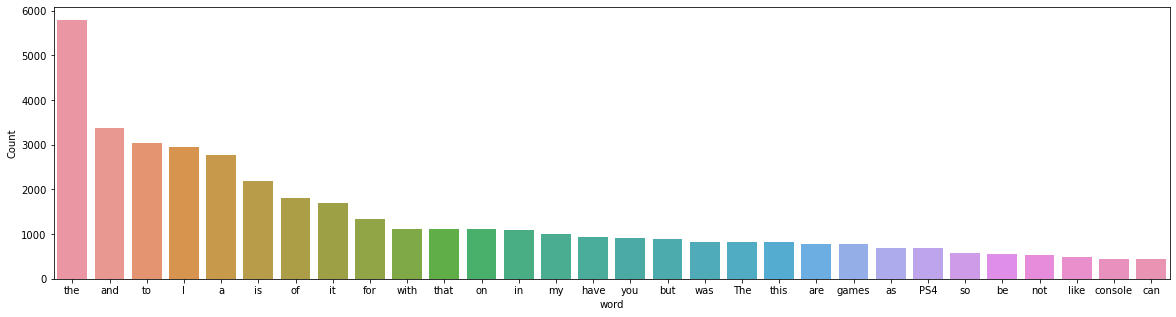

In [82]:
freq_words(ps4reviews_positive['comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br> But these are not necessary words because these words don't show true sentiment.<br> The dataset will need to be cleaned further in order to prepare this dataset for the model.

The following code is run in order to remove the characters and symbols from the review dataset:

In [83]:
ps4reviews_positive['comment'] = ps4reviews_positive['comment'].str.replace("[^a-zA-Z#]"," ")

This code is run in order to bring stopwords into the notebook:

In [84]:
stop_words = set(stopwords.words('english'))

This function is used in order to remove the stopwords and for reusability as well:

In [85]:
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [86]:
ps4reviews_positive['comment'] = ps4reviews_positive['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

This code is run to remove stopwords from the text:

In [87]:
reviews = [remove_stopwords(r.split()) for r in ps4reviews_positive['comment']]

This code is run in order to make the text lowercase:

In [88]:
reviews = [r.lower() for r in reviews]

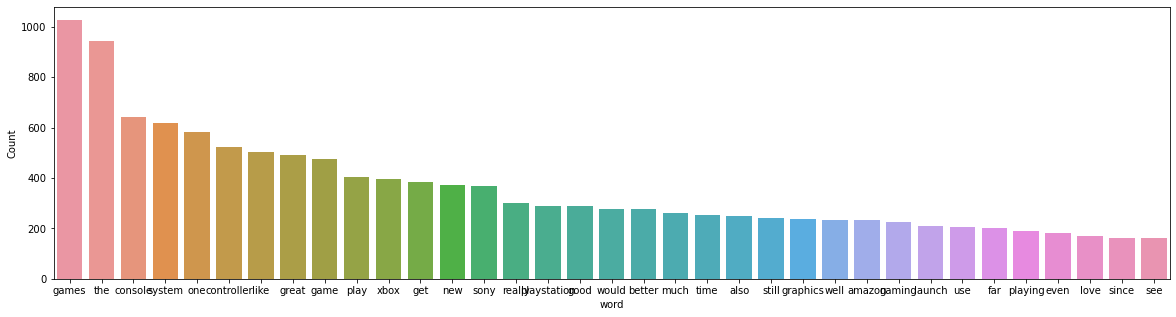

In [89]:
freq_words(reviews, 35)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting closer 
to be used for the model.<br> The next step is to lemmatize the data.

The following pieces of code are run in order to load in Spacy and use the following function to lemmatize the data.<br> 
This code will be helpful for reusability purposes as well:

In [90]:
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])

def lemmatization(texts, tags = ['NOUN', 'ADJ']): 
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

This code is done in order to split the words into tokens:

In [91]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['bought', 'system', 'purchasing', 'returning', 'different', 'slims', 'one', 'pro', 'none', 'newer', 'models', 'would', 'play', 'two', 'used', 'games', 'light', 'scratches', 'discs', 'the', 'discs', 'run', 'fine', 'older', 'model', 'issues', 'system', 'either', 'bad', 'batch', 'area', 'newer', 'systems', 'made', 'run', 'discs', 'blemish', 'conspiracy', 'happy', 'purchase']


The code here is run in order to lemmatize the reviews:

In [92]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

['bought', 'system', 'different', 'slim', 'none', 'new', 'model', 'game', 'light', 'disc', 'old', 'model', 'issue', 'system', 'bad', 'batch', 'area', 'new', 'system', 'purchase']


The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [93]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

ps4reviews_positive['reviews'] = reviews_3

Here,a frequency bar graph of the top 20 words is generated with the appended dataframe from the previous step:

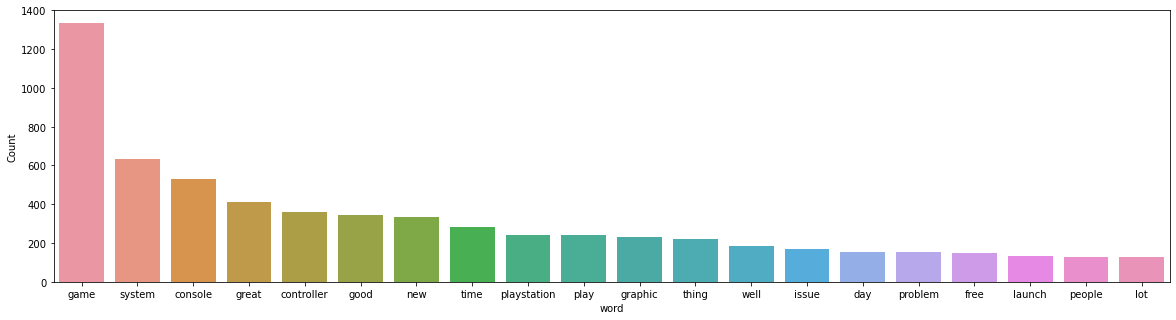

In [94]:
freq_words(ps4reviews_positive['reviews'], 20)

As can be seen, the tokens are now cleaner as words such as "game", "system", and "console" are now clearly showing in the dataset.<br>
The dataset is now ready for model building.

#                            LDA Model (PS4 Positive Reviews)

The code below is run in order to incorporate the reviews into a dictionary in order to set up the LDA Model:

In [95]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.<br>
The number of topics I chose through trial and error were 3.

In [96]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 3,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Here, this code is being run to print the topics and the words associated with it:

In [97]:
lda_model.print_topics()

[(0,
  '0.038*"game" + 0.024*"console" + 0.021*"system" + 0.018*"time" + 0.016*"controller" + 0.014*"day" + 0.013*"good" + 0.013*"great" + 0.012*"launch" + 0.011*"new"'),
 (1,
  '0.043*"product" + 0.042*"great" + 0.015*"power" + 0.014*"good" + 0.012*"day" + 0.010*"package" + 0.010*"happy" + 0.009*"item" + 0.009*"problem" + 0.008*"time"'),
 (2,
  '0.049*"game" + 0.024*"system" + 0.019*"console" + 0.018*"great" + 0.015*"good" + 0.015*"new" + 0.013*"controller" + 0.010*"playstation" + 0.009*"graphic" + 0.009*"well"')]

This code is run to generate the LDA model and present it via a graphical bubble plot:

In [98]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.107008  0.117021       1        1  78.734306
0     -0.116439 -0.113774       2        1  11.583504
1      0.223447 -0.003247       3        1   9.682190, topic_info=        Term         Freq        Total Category  logprob  loglift
197    great   588.000000   588.000000  Default  30.0000  30.0000
12      game  1275.000000  1275.000000  Default  29.0000  29.0000
103  console   516.000000   516.000000  Default  28.0000  28.0000
61   product   129.000000   129.000000  Default  27.0000  27.0000
46    system   633.000000   633.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
199  perfect    15.749497    48.648556   Topic3  -5.2057   1.2071
17    launch    16.690907    97.305252   Topic3  -5.1476   0.5719
132   review    16.797947   105.500420   Topic3  -5.1412   0.4974
251    order    15.103695    60.215202   Topic3  -5.2476   0.9519
217    price    15.376373    78.128751   Topic3  -5.2297   0.7094

[215 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1339      1  0.654252    account
1339      2  0.348934    account
2235      3  0.893253    address
95        1  0.806576    amazing
95        2  0.185420    amazing
...     ...       ...        ...
1358      2  0.966213    weekend
379       1  0.996845       well
1212      2  0.952172  wonderful
93        1  0.962010       year
93        2  0.039000       year

[253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

As can be seen above, there are 3 topics which were created.<br> Based on the words within each topic, I can take a reasonable guess as to what the topics are about:<br>

Topic 1: Positive Review for PS4 features: Graphics, controller, play, well, easy<br>
Topic 2: Positive Reviews for PS4 internal features: amazing, sysytem, awesome, feature<br>
Topic 3: Positive Reviews on PS4 speed and power.<br>

It seems to me that people were really happy with the PS4 based on the firmware and software.<br>
There were positive comments for the controller, graphics, and the power of the PS4 as well.<br>

#                                  Data Cleaning (PS4 Negative Reviews)

The following section is done in order to prepare the PS4 negative reviews for the LDA model.<br>
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.<br>
Visualizations will also be built in order to take a better look at the data.

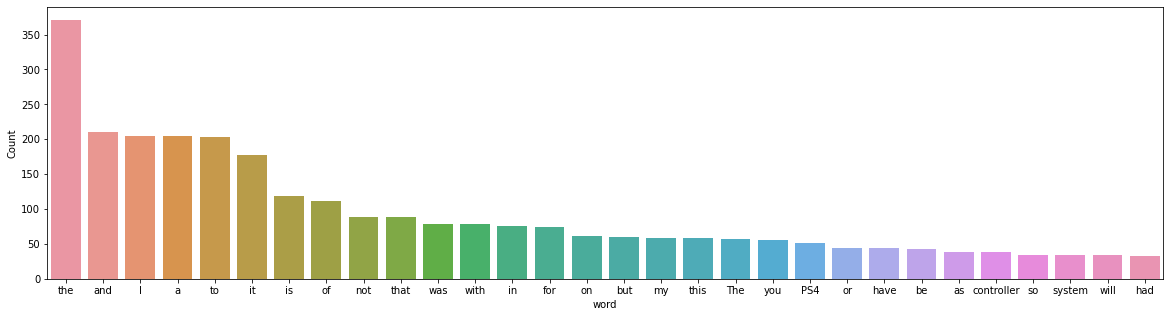

In [99]:
freq_words(ps4reviews_negative['comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br> But these are not necessary words because these words don't show true sentiment.<br> The dataset will need to be cleaned further in order to prepare this dataset for the model.

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [100]:
ps4reviews_negative['comment'] = ps4reviews_negative['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

The following code is run to remove stopwords from the text:

In [101]:
reviews = [remove_stopwords(r.split()) for r in ps4reviews_negative['comment']]

This code is run to make the text lowercase:

In [102]:
reviews = [r.lower() for r in reviews]

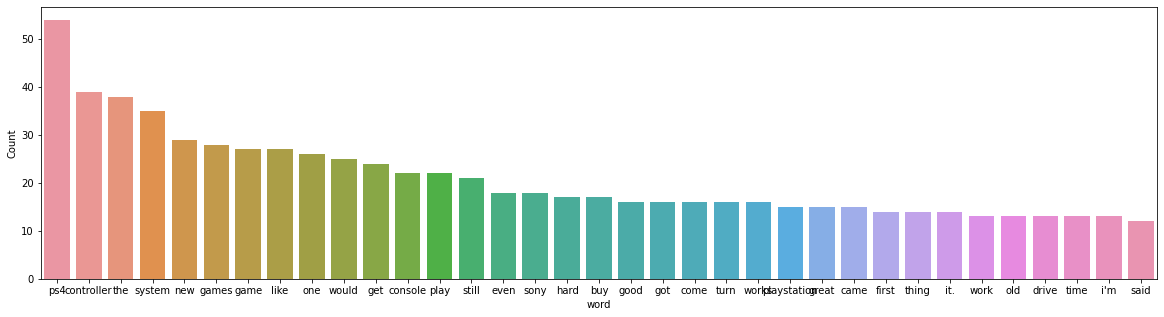

In [103]:
freq_words(reviews, 35)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting closer to be used for the model.<br> The next step is to lemmatize the data.

This code is done in order to split the words of the words into tokens:

In [104]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['this', 'first', 'console', "i've", 'purchased', 'myself.', 'the', 'product', 'used', 'labelled', 'good', 'sold', 'amazon.com', 'services,', 'inc.', 'unfortunately', 'controller', 'worked', 'close', 'console.', 'the', 'controller', 'within', 'feet', 'console', 'work', 'even', 'connection', 'sometime', 'drops', 'out.', 'using', 'usb', 'cable', 'question', 'method', 'connection', 'via', 'bluetooth.', 'initially', 'thought', 'controller', 'issue', 'went', 'bought', 'new', 'controller', 'still', 'issue', 'persisted', 'meaning', 'console', 'defective.', 'either', 'device', 'got', 'damaged', 'delivery', 'properly', 'test', 'console.', 'the', 'device', 'still', 'usable', 'fullest', 'potential.', 'this', 'disappointing', 'expensive', 'purchase', 'brings', 'caution', 'towards', 'labeling', 'used', 'products', 'sold', 'amazon.']


This code below is run in order to lemmatize the reviews:

In [105]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) 

['first', 'console', 'product', 'good', 'sold', 'service', 'close', 'console', 'controller', 'foot', 'work', 'cable', 'question', 'method', 'connection', 'issue', 'new', 'controller', 'issue', 'console', 'device', 'delivery', 'console', 'device', 'usable', 'full', 'potential', 'disappointing', 'expensive', 'purchase', 'caution', 'product']


The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [106]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

ps4reviews_negative['reviews'] = reviews_3


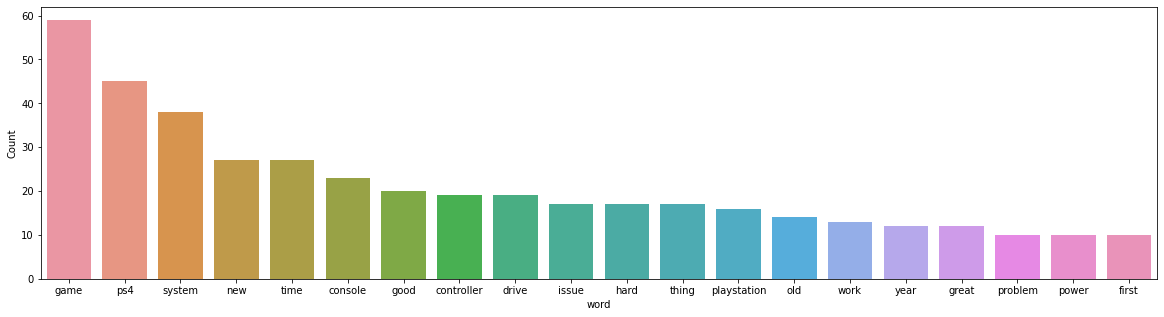

In [107]:
freq_words(ps4reviews_negative['reviews'], 20)

As can be seen, the tokens are now cleaner as words such as "game", "system", and "console" are now clearly showing in the dataset.<br>The dataset is now ready for model building.

#                                   LDA Model (PS4 Negative Reviews)

The code below is run in order to incorporate the reviews into a dictionary in order to set up the LDA Model.


In [108]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.<br>
The number of topics I chose through trial and error were 4.

In [109]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 4,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Here, this code is being run to print the topics and the words associated with it:

In [110]:
lda_model.print_topics()

[(0,
  '0.032*"ps4" + 0.026*"system" + 0.022*"controller" + 0.021*"new" + 0.016*"good" + 0.015*"game" + 0.015*"work" + 0.012*"time" + 0.010*"cable" + 0.010*"disc"'),
 (1,
  '0.044*"game" + 0.028*"ps4" + 0.019*"system" + 0.016*"hard" + 0.015*"drive" + 0.015*"console" + 0.013*"product" + 0.013*"time" + 0.012*"old" + 0.011*"playstation"'),
 (2,
  '0.020*"ps4" + 0.017*"issue" + 0.015*"great" + 0.013*"problem" + 0.012*"console" + 0.010*"sound" + 0.010*"day" + 0.009*"playstation" + 0.008*"code" + 0.008*"month"'),
 (3,
  '0.017*"time" + 0.015*"description" + 0.015*"playstation" + 0.014*"system" + 0.011*"model" + 0.010*"console" + 0.009*"game" + 0.009*"light" + 0.009*"blue" + 0.009*"happy"')]

This code is run to generate the LDA model and present it via a graphical bubble plot:

In [111]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.111155  0.010348       1        1  40.421462
0     -0.010930 -0.109029       2        1  28.166165
2     -0.089741  0.016495       3        1  15.991088
3     -0.010483  0.082186       4        1  15.421285, topic_info=            Term       Freq      Total Category  logprob  loglift
353  description   7.000000   7.000000  Default  30.0000  30.0000
69   playstation  16.000000  16.000000  Default  29.0000  29.0000
105        great  10.000000  10.000000  Default  28.0000  28.0000
70           ps4  46.000000  46.000000  Default  27.0000  27.0000
39         issue  14.000000  14.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
105        great   1.823089  10.174146   Topic4  -5.1056   0.1501
7           good   1.735386  17.555071   Topic4  -5.1549  -0.4447
358        piece   1.405506   4.159372   Topic4  -5.3658   0.7845
326     download   1.400900   4.087630   Topic4  -5.3690   0.7986
88          item   1.400274   7.743812   Topic4  -5.3695   0.1592

[265 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
77        1  0.969528      -
578       4  0.516519    aaa
191       1  0.602150   able
191       2  0.240860   able
191       3  0.120430   able
...     ...       ...    ...
47        4  0.168868   work
344       2  0.927695  worth
95        1  0.509556   year
95        2  0.339704   year
95        3  0.169852   year

[333 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

As can be seen above, there are 4 topics which are clearly separated. Based on the words within each topic, I can take a reasonable guess to what the topics are about:<br>

Topic 1: Possible issues with graphics and complaints about system being old: hard, drive, old, product<br>
Topic 2: Possible complaints over the price and length of warranty: disc, money, issue, warranty<br>
Topic 3: Issues with product hardware: eject, disc, warranty, sound, issue<br>
Topic 4: Calls for refund due to the condition of the PS4 Refund,death, condition<br>

It seems to me that most customers complained about the PS4 for the system being old, length of warranty, hardware issues such as disc ejection,and sound.<br>There were also issues with customers wanting a refund for possible product defects.

#                                              Data Splitting: PS5 Reviews

Here, the PS5 reviews are split into the negative set with ratings <= 3:

In [112]:
negative =  ps5reviews['Rating'] <= 3
ps5reviews_negative = ps5reviews[negative]
ps5reviews_negative.head(5)

,Rating,Comment
0,1,This will no doubt come off as someo...
1,1,Taking advantage of high demand
2,1,I wait all night just to purchase th...
3,1,"Between Nvidia, Sony and Microsoft, ..."
4,1,I've been a PlayStation guy for a lo...


In [113]:
ps5reviews_negative.shape

(339, 2)

There are 339 reviews with 2 columns in the dataframe.

Here, the PS5 reviews are split into the positive set with ratings >= 4:

In [114]:
positive =  ps5reviews['Rating'] >= 4
ps5reviews_positive = ps5reviews[positive]
ps5reviews_positive.head(5)

,Rating,Comment
58,5,We all know what this console is cap...
59,5,Going over hardware and software. No...
88,4,I was so excited to have been able t...
98,5,"Absolutely incredible, the haptic fe..."
109,5,Glad to have gotten the PS5 so early...


In [115]:
ps5reviews_positive.shape

(742, 2)

There are 742 reviews and 2 columsn in the dataframe.

#                                                    Data Cleaning (PS5 Positive Reviews)

The following section is done in order to prepare the PS5 positive reviews for the LDA model.<br>
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.<br>
Visualizations will also be built in order to take a better look at the data.

The following produces a frequency bar graph for the PS5 positive reviews:

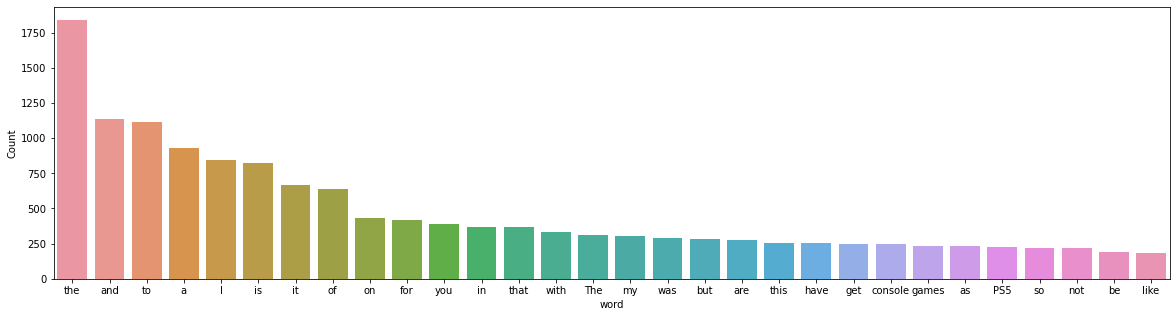

In [116]:
freq_words(ps5reviews_positive['Comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br>But these are not necessary words because these words don't show true sentiment.<br>The dataset will need to be cleaned further in order to prepare this dataset for the model.

The following code is run in order to remove the characters and symbols from the review dataset:

In [117]:
ps5reviews_positive['Comment'] = ps5reviews_positive['Comment'].str.replace("[^a-zA-Z#]"," ")

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [118]:
ps5reviews_positive['Comment'] = ps5reviews_positive['Comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

The following code is run in order to remove the stopwords from the data:

In [119]:
reviews = [remove_stopwords(r.split()) for r in ps5reviews_positive['Comment']]

This code is run to make the text lowercase:

In [120]:
reviews = [r.lower() for r in reviews]

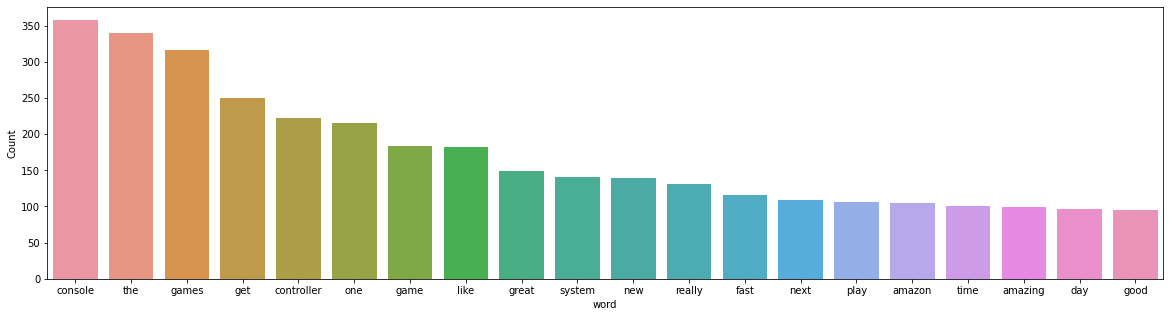

In [121]:
freq_words(reviews, 20)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting closer to be used for the model.<br>The next step is to lemmatize the data.

The following code is run in order to separate the text into tokens:

In [122]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['going', 'hardware', 'software', 'not', 'going', 'every', 'exact', 'technical', 'specs', 'easily', 'look', 'software', 'change', 'overtime', 'review', 'software', 'launch', 'hardware', 'hiccups', 'failures', 'near', 'future', 'update', 'review', 'hardware', 'physical', 'looks', 'futuristic', 'yet', 'tacky', 'personal', 'opinion', 'looks', 'really', 'matter', 'long', 'play', 'next', 'gen', 'games', 'welllarge', 'console', 'standing', 'tallest', 'home', 'video', 'console', 'lot', 'air', 'vents', 'throughout', 'making', 'aerodynamic', 'cool', 'quiet', 'overheat', 'get', 'hot', 'consecutive', 'gameplay', 'hours', 'this', 'may', 'change', 'future', 'games', 'require', 'performance', 'system', 'similar', 'fate', 'like', 'whisper', 'quiet', 'beginning', 'became', 'louder', 'years', 'graphical', 'intensive', 'games', 'has', 'led', 'lights', 'giving', 'look', 'face', 'plate', 'easy', 'take', 'future', 'customization', 'options', 'free', 'download', 'space', 'consoleswapping', 'sdd', 'easy', 'x

This code is run in order to lemmatize the data:

In [123]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) 

['hardware', 'software', 'exact', 'technical', 'spec', 'software', 'change', 'overtime', 'software', 'failure', 'future', 'update', 'futuristic', 'tacky', 'personal', 'opinion', 'long', 'play', 'home', 'video', 'console', 'lot', 'air', 'vent', 'aerodynamic', 'cool', 'quiet', 'overheat', 'hot', 'consecutive', 'gameplay', 'hour', 'future', 'game', 'performance', 'system', 'similar', 'fate', 'whisper', 'quiet', 'beginning', 'loud', 'year', 'graphical', 'intensive', 'game', 'light', 'look', 'face', 'plate', 'future', 'customization', 'option', 'free', 'download', 'space', 'play', 'method', 'screw', 'upside', 'standard', 'compatible', 'sdd', 'transfer', 'internal', 'storagecome', 'console', 'flat', 'stand', 'required', 'horizontal', 'position', 'vertical', 'position', 'stand', 'grip', 'rubber', 'foot', 'super', 'speed', 'port', 'future', 'proof', 'guess', 'current', 'accessory', 'compatible', 'disappointed', 'official', 'pulse', 'headset', 'camera', 'optical', 'audio', 'port', 'surround', '

The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [124]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

ps5reviews_positive['reviews'] = reviews_3

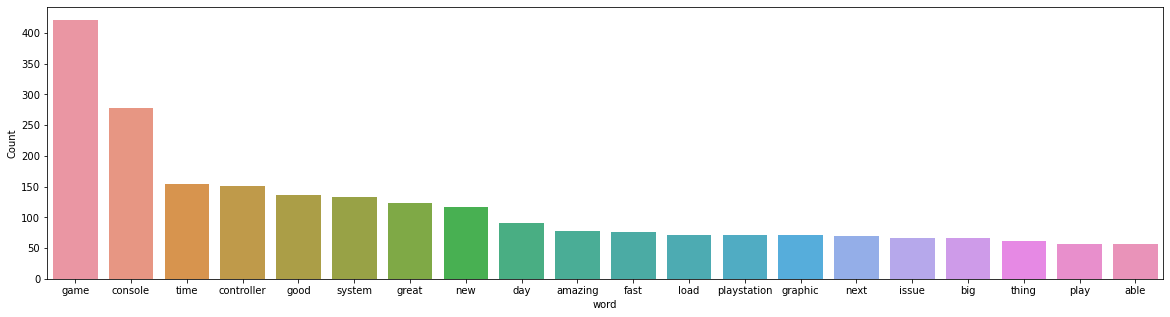

In [125]:
freq_words(ps5reviews_positive['reviews'], 20)

As can be seen, the tokens are now cleaner as words such as "game", "system", and "console" are now clearly showing in the dataset.<br> The dataset is now ready for model building.

#                                                        LDA Model (PS5 Positive Reviews)

The code below is run in order to incorporate the reviews into a dictionary in order to set up the LDA Model.

In [126]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.<br>
The number of topics chosen through trial and error were 4.

In [127]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 4,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Here, this code is being run to print the topics and the words associated with it:

In [128]:
lda_model.print_topics()

[(0,
  '0.036*"console" + 0.028*"game" + 0.017*"love" + 0.014*"new" + 0.012*"controller" + 0.011*"great" + 0.010*"next" + 0.010*"design" + 0.010*"generation" + 0.009*"good"'),
 (1,
  '0.036*"console" + 0.030*"great" + 0.026*"good" + 0.019*"game" + 0.018*"time" + 0.015*"day" + 0.014*"controller" + 0.012*"system" + 0.012*"able" + 0.010*"lucky"'),
 (2,
  '0.041*"game" + 0.019*"day" + 0.018*"playstation" + 0.016*"graphic" + 0.016*"good" + 0.016*"worth" + 0.014*"console" + 0.013*"time" + 0.011*"play" + 0.011*"nice"'),
 (3,
  '0.046*"game" + 0.019*"console" + 0.018*"system" + 0.017*"amazing" + 0.015*"time" + 0.014*"next" + 0.013*"controller" + 0.012*"new" + 0.011*"great" + 0.010*"good"')]

This code is run to visualize the LDA model into a graphical bubble plot:

In [129]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.015086 -0.031586       1        1  43.221736
0      0.115120  0.009554       2        1  22.512538
1     -0.069885 -0.073759       3        1  21.167706
2     -0.060320  0.095790       4        1  13.098020, topic_info=        Term        Freq       Total Category  logprob  loglift
30     great  154.000000  154.000000  Default  30.0000  30.0000
14       day   93.000000   93.000000  Default  29.0000  29.0000
798     love   66.000000   66.000000  Default  28.0000  28.0000
12   console  286.000000  286.000000  Default  27.0000  27.0000
509  graphic   66.000000   66.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
282    issue    7.989086   67.229302   Topic4  -5.2031  -0.0973
35    launch    6.622075   45.405962   Topic4  -5.3908   0.1075
21      fast    6.926501   71.928523   Topic4  -5.3458  -0.3076
331   gaming    6.110324   37.670695   Topic4  -5.4712   0.2138
49    review    5.579786   25.908542   Topic4  -5.5620   0.4973

[311 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
60        1  0.407837     able
60        2  0.084966     able
60        3  0.492803     able
60        4  0.033986     able
731       2  0.889507  account
...     ...       ...      ...
265       1  0.684517     year
265       2  0.152115     year
265       3  0.126762     year
265       4  0.025352     year
375       4  0.836992    young

[499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3])

As can be seen above, there are 4 topics which are clearly separated. Based on the words within each topic, I can take a reasonable guess as to what the topics are about:<br>

Topic 1: Great reviews on how fast the system is: Load, fast, awesome, time, feedback<br>
Topic 2: Great reviews on the design and controller and speed: design, controller, speed, performance<br>
Topic 3: Positive reviews on the hardware and the system being quiet.<br>
Topic 4: Positive comments on the graphics and the system being perfect: Graphic, worth, love, release, perfect<br>

It seems to me that most customers were really happy with how fast the PS5 is compared to the PS4.<br> 
There seems to be great feedback on the controller and the system design.<br> "Quiet" shows up which could possibly mean
how quiet the system is when running games.<br> Some consumers even called the system perfect.

#                                      Data Cleaning (PS5 Negative Reviews)

The following section is done in order to prepare the PS5 negative reviews for the LDA model.
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.
Visualizations will also be built in order to take a better look at the data.

The following code is run to generate a frequency bar graph for the negative reviews:

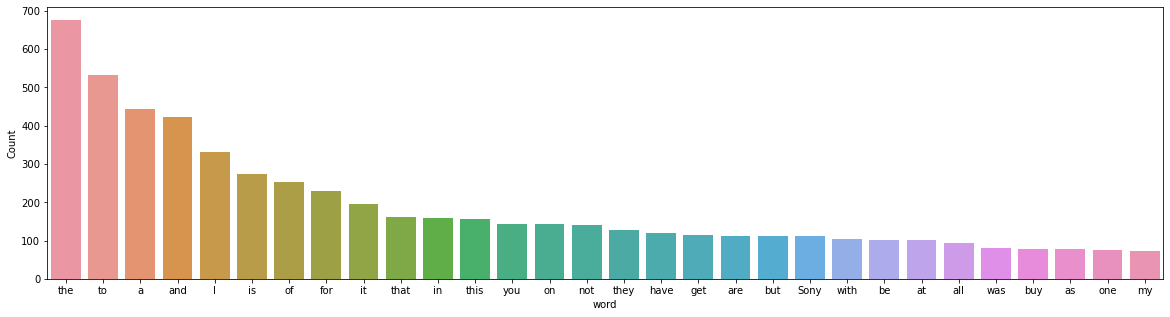

In [130]:
freq_words(ps5reviews_negative['Comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br> But these are not necessary words because these words don't show true sentiment.<br>The dataset will need to be cleaned further in order to prepare this dataset for the model.

This code removes the characters and samples from the text dataset:

In [131]:
ps5reviews_negative['Comment'] = ps5reviews_negative['Comment'].str.replace("[^a-zA-Z#]"," ")

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [132]:
ps5reviews_negative['Comment'] = ps5reviews_negative['Comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

This code removes the stopwords from the text:

In [133]:
reviews = [remove_stopwords(r.split()) for r in ps5reviews_negative['Comment']]

Here, the text is lowercased:

In [134]:
reviews = [r.lower() for r in reviews]

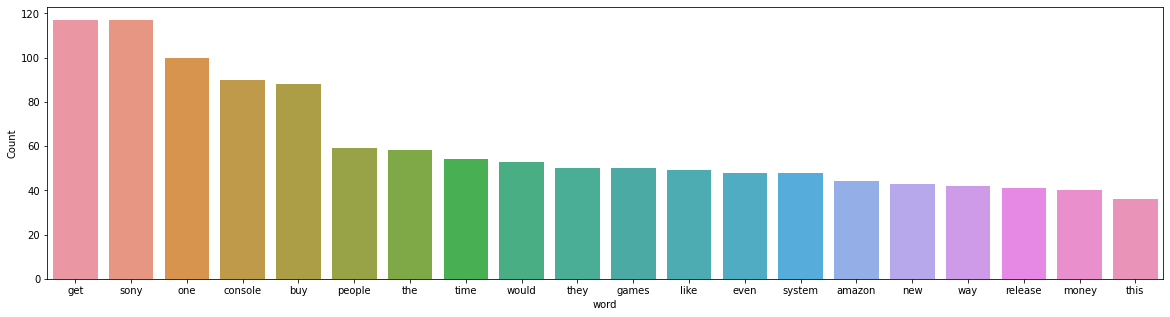

In [135]:
freq_words(reviews, 20)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting closer to be used for the model.<br>The next step is to lemmatize the data.

Here, the text within the dataset is split into tokens:

In [136]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['taking', 'advantage', 'high', 'demand']


The data is lemmatized through this code:

In [137]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) 

['advantage', 'high', 'demand']


The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [138]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

ps5reviews_negative['reviews'] = reviews_3

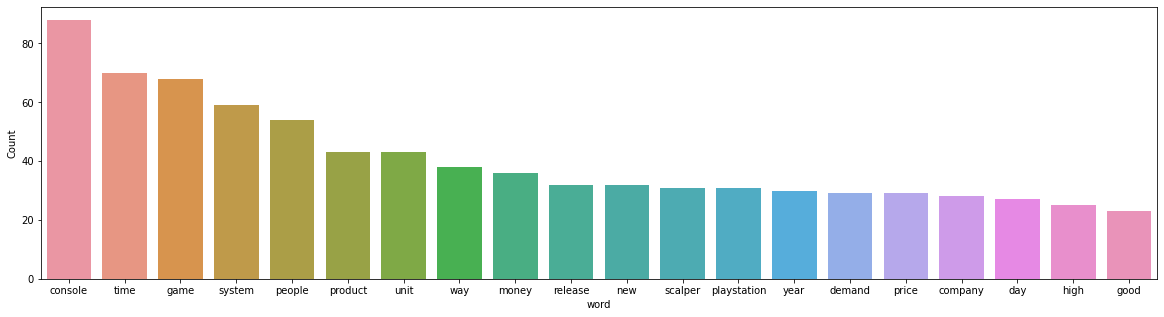

In [139]:
freq_words(ps5reviews_negative['reviews'], 20)

As can be seen, the tokens are now clearer as words such as "game", "system", and "money" are now clearly showing in the dataset.<br> The dataset is now ready for model building.

#                                        LDA Model (PS5 Negative Reviews)

The code below is run in order to incorporate the negative reviews into a dictionary in order to set up the LDA Model.


In [140]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.<br>
The number of topics chosen through trial and error were 4.

In [141]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 4,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Here, this code is being run to print the topics and the words associated with it:

In [142]:
lda_model.print_topics()

[(0,
  '0.034*"console" + 0.021*"time" + 0.020*"people" + 0.019*"money" + 0.018*"product" + 0.016*"unit" + 0.015*"company" + 0.014*"price" + 0.012*"release" + 0.011*"year"'),
 (1,
  '0.020*"console" + 0.018*"people" + 0.018*"game" + 0.014*"hope" + 0.014*"purchase" + 0.014*"way" + 0.010*"good" + 0.009*"bunch" + 0.008*"high" + 0.008*"new"'),
 (2,
  '0.030*"game" + 0.027*"system" + 0.019*"price" + 0.015*"new" + 0.015*"time" + 0.013*"product" + 0.013*"playstation" + 0.011*"year" + 0.010*"worth" + 0.010*"good"'),
 (3,
  '0.020*"console" + 0.017*"time" + 0.016*"unit" + 0.015*"day" + 0.014*"system" + 0.013*"game" + 0.010*"launch" + 0.009*"point" + 0.009*"release" + 0.008*"controller"')]

This code is run to visualize the LDA model into a graphical bubble plot:

In [143]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.151686 -0.023870       1        1  32.969281
3     -0.020752  0.102432       2        1  22.847743
2     -0.060218  0.018171       3        1  22.381717
1     -0.070716 -0.096734       4        1  21.801259, topic_info=        Term       Freq      Total Category  logprob  loglift
120     game  55.000000  55.000000  Default  30.0000  30.0000
48      unit  36.000000  36.000000  Default  29.0000  29.0000
76      hope  12.000000  12.000000  Default  28.0000  28.0000
2    company  25.000000  25.000000  Default  27.0000  27.0000
70     price  39.000000  39.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
274    month   4.524436  11.580357   Topic4  -5.2701   0.5834
102     many   4.583545  14.809603   Topic4  -5.2571   0.3504
97       day   4.766820  24.025056   Topic4  -5.2179  -0.0942
47      time   5.076288  62.332991   Topic4  -5.1550  -0.9847
45    system   4.169523  52.886053   Topic4  -5.3518  -1.0171

[280 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
225       1  0.269681      able
225       2  0.269681      able
225       3  0.337101      able
225       4  0.134841      able
709       1  0.743053  absolute
...     ...       ...       ...
57        3  0.654538     worth
57        4  0.290906     worth
52        1  0.539812      year
52        2  0.107962      year
52        3  0.359875      year

[400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

As can be seen above, there are 4 topics which are clearly separated.<br>Based on the words within each topic, I can take a reasonable guess to what the topics are about:<br>

Topic 1: Complaints mostly on bots: Scam,bot, ridiculousness,reseller<br>
Topic 2: Complaints mostly on the supply and demand of the product<br>
Topic 3: Complaints mostly on the price of the PS5<br>
Topic 4: Complaints on the PS5 crashing<br>

It seems to me that most customers were really unhappy with the scalpers and bots that bought most of the PS5's
online given the COVID 19 pandemic.<br>There were complaints on the limited supply and high demand of the product.<br>
There were also complaints about the price of the PS5.<br>
Finally, there were a few cases where the PS5 tended to crash for some customers.<br> 

These are interesting results because there are not a lot of the complaints on the product itself.<br>The complaints are mostly
on obtaining the PS5 which has been difficult to get for consumers due to the pandemic. 

#                                                    Data Splitting: Xbox One X Reviews

Here, the Xbox One X reviews are split into the positive set with ratings >= 4:

In [144]:
positive =  xboxonexreviews['stars'] >= 4
xboxonex_positive = xboxonexreviews[positive]
xboxonex_positive.head(5)

,stars,comment
6,5,It’s a behemoth simple put. Besides ...
8,5,Let me start off by saying I am not ...
12,5,Tons of PowerGamepassHaloWhat more c...
16,5,To start off I would consider myself...
18,5,Preorders were a mess but did you re...


In [145]:
xboxonex_positive.shape

(1853, 2)

There are 1,853 positive review rows and 2 columns in the dataframe.

Here, the Xbox One X  reviews are split into the negative set with ratings <= 3:

In [146]:
negative =  xboxonexreviews['stars'] <= 3
xboxonex_negative = xboxonexreviews[negative]
xboxonex_negative.head(5)

,stars,comment
0,1,This should be illegal. What a scumm...
1,1,Hope you never sell them
2,1,"Wait for the stock to replenish, all..."
3,1,"How dare you Amazon! $1,500.00? Th..."
4,1,annoying


In [147]:
xboxonex_negative.shape

(612, 2)

There are 612 negative review rows and 2 columns in the dataframe.

#                                 Data Cleaning (Xbox One X Positive Reviews)

The following section is done in order to prepare the Xbox One X positive reviews for the LDA model.<br>
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.<br>
Visualizations will also be built in order to take a better look at the data.

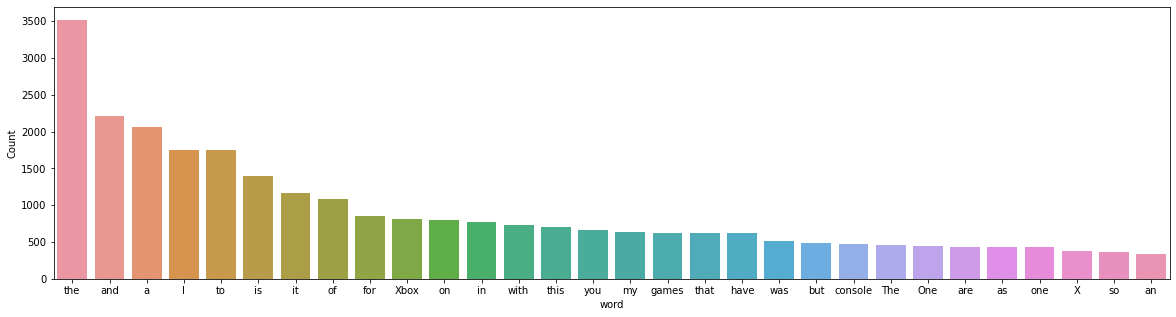

In [148]:
freq_words(xboxonex_positive['comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br>But these are not necessary words because these words don't show true sentiment.<br>The dataset will need to be cleaned further in order to prepare this dataset for the model.

This code removes the characters and symbols from the dataset:

In [149]:
xboxonex_positive['comment'] = xboxonex_positive['comment'].str.replace("[^a-zA-Z#]"," ")

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [150]:
xboxonex_positive['comment'] = xboxonex_positive['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

This code removes the stopwords from the dataset:

In [151]:
reviews = [remove_stopwords(r.split()) for r in xboxonex_positive['comment']]

This code makes the text lowercase:

In [152]:
reviews = [r.lower() for r in reviews]

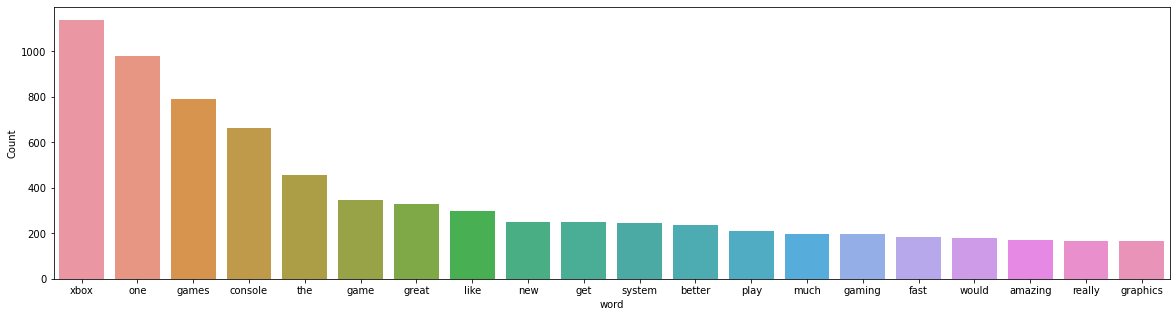

In [153]:
freq_words(reviews, 20)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting closer to 
for the model to use.<br>The next step is to lemmatize the data.

Here, the words are split into tokens:

In [154]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['let', 'start', 'saying', 'xbox', 'fan', 'boy', 'lol', 'mostly', 'played', 'past', 'years', 'intrigued', 'xbox', 'series', 'user', 'experience', 'they', 'really', 'seem', 'like', 'listening', 'generation', 'shows', 'the', 'interface', 'like', 'butter', 'moves', 'quickly', 'hardly', 'waiting', 'game', 'pass', 'amazing', 'option', 'xbox', 'amazing', 'selection', 'games', 'right', 'fingertips', 'monthly', 'fee', 'xbox', 'really', 'got', 'user', 'experience', 'honestly', 'say', 'definitely', 'worth', 'enjoying', 'lot', 'games', 'played', 'confident', 'saying', 'great', 'experience', 'xbox', 'series', 'blown', 'away', 'gets', 'little', 'hot', 'breathable', 'location', 'would', 'recommend', 'well', 'excited', 'play', 'xbox', 'one', 'games', 'missed', 'and', 'new', 'games', 'course', 'overall', 'really', 'recommend']


Below, the positive reviews are lemmatized:

In [155]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) 

['fan', 'boy', 'past', 'year', 'user', 'experience', 'generation', 'interface', 'butter', 'move', 'game', 'amazing', 'amazing', 'game', 'monthly', 'user', 'experience', 'worth', 'lot', 'game', 'confident', 'great', 'experience', 'little', 'hot', 'breathable', 'location', 'excited', 'game', 'new', 'game']


The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [156]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

xboxonex_positive['reviews'] = reviews_3

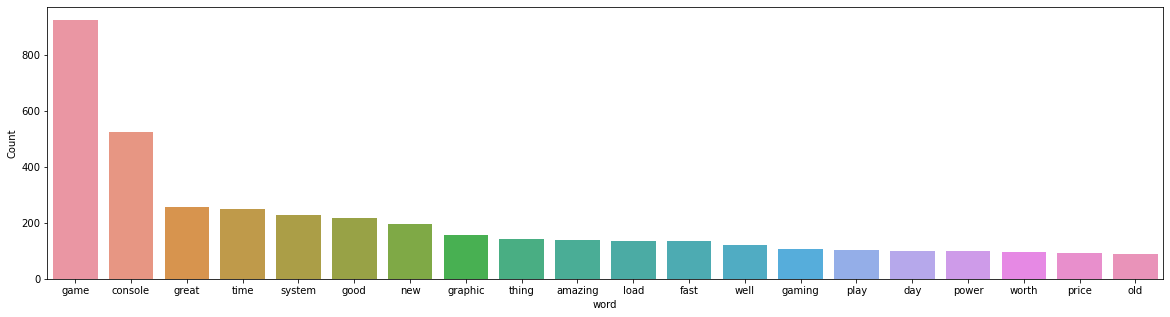

In [157]:
freq_words(xboxonex_positive['reviews'], 20)

As can be seen, the tokens are now clearer as words such as "game", "system", and "time" are now clearly showing in the dataset.<br>The dataset is now ready for model building.

#                LDA Model (Xbox One X Positive Reviews)
The code below is run in order to incorporate the reviews into a dictionary in order to set up the LDA Model.

In [158]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.<br>
The number of topics I chose through trial and error were 3.

In [159]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 3,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Here, this code is being run to print the topics and the words associated with it.

In [160]:
lda_model.print_topics()

[(0,
  '0.062*"game" + 0.030*"console" + 0.012*"system" + 0.011*"thing" + 0.010*"good" + 0.010*"time" + 0.009*"gaming" + 0.008*"powerful" + 0.007*"nice" + 0.007*"year"'),
 (1,
  '0.064*"great" + 0.036*"console" + 0.035*"good" + 0.025*"game" + 0.017*"new" + 0.014*"system" + 0.011*"product" + 0.011*"work" + 0.010*"issue" + 0.010*"box"'),
 (2,
  '0.036*"game" + 0.033*"amazing" + 0.024*"fast" + 0.023*"time" + 0.021*"love" + 0.018*"graphic" + 0.018*"worth" + 0.016*"load" + 0.015*"console" + 0.015*"awesome"')]

This code is run to visualize the LDA model into a graphical bubble plot:

In [161]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.025186 -0.108661       1        1  49.790062
1     -0.140891  0.038332       2        1  28.598409
2      0.115705  0.070329       3        1  21.611529, topic_info=           Term        Freq       Total Category  logprob  loglift
25        great  394.000000  394.000000  Default  30.0000  30.0000
0       amazing  192.000000  192.000000  Default  29.0000  29.0000
39         fast  144.000000  144.000000  Default  28.0000  28.0000
203        love  119.000000  119.000000  Default  27.0000  27.0000
72         good  321.000000  321.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
33          new   22.945646  184.111328   Topic3  -5.2420  -0.5505
89          old   20.039373   83.374723   Topic3  -5.3774   0.1063
817       money   18.479927   53.609646   Topic3  -5.4585   0.4669
452    original   18.579262   80.945422   Topic3  -5.4531   0.0602
122  difference   18.503167   83.560100   Topic3  -5.4572   0.0243

[227 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
340       2  0.969800   access
341       2  0.969762  adapter
0         1  0.254332  amazing
0         2  0.005190  amazing
0         3  0.742233  amazing
...     ...       ...      ...
733       1  0.165873    wrong
733       2  0.829367    wrong
37        1  0.744175     year
37        2  0.255146     year
37        3  0.010631     year

[307 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

As can be seen above, there are 3 topics which are clearly separated.<br>Based on the words within each topic, I can take a reasonable guess as to what the topics are about:<br>

Topic 1: The topic seems to be on the power and quality of the system: powerful, drive, graphic, quality, amazing<br>
Topic 2: The topic seems to on the condition of the Xbox and the controller: perfect, controller, excellent, condition<br>
Topic 3: The topic is focused on the speed of the Xbox: fast, time, awesome, quick<br>

Based on the reviews, it seems most customers were happy on how quick the system was,the graphics, and the experience.<br>
There were also positive reviews based on the controller, firmware, size, and features.<br>Furthermore, there seems to be positive reviews on the size and quality of the system with some consumers calling the product perfect.

#                              Data Cleaning (Xbox One X Negative Reviews)

The following section is done in order to prepare the Xbox One X negative reviews for the LDA model.
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.
Visualizations will also be built in order to take a better look at the data.

Here is a frequency bar graph for the negative Xbox One X negative comments:

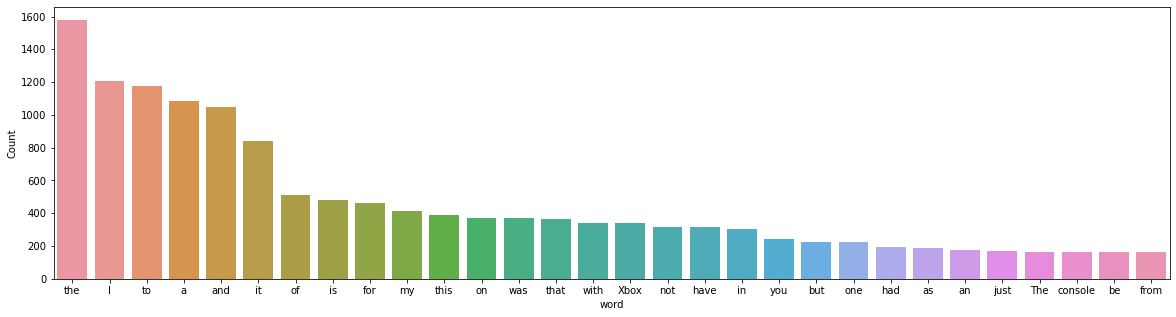

In [162]:
freq_words(xboxonex_negative['comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br>But these are not necessary words because these words don't show true sentiment.<br>The dataset will need to be cleaned further in order to prepare this dataset for the model.

This code removes the characters and samples from the text dataset:

In [163]:
xboxonex_negative['comment'] = xboxonex_negative['comment'].str.replace("[^a-zA-Z#]"," ")

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [164]:
xboxonex_negative['comment'] = xboxonex_negative['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

This code removes the stopwords from the dataset:

In [165]:
reviews = [remove_stopwords(r.split()) for r in xboxonex_negative['comment']]

This code makes the text lowercase:

In [166]:
reviews = [r.lower() for r in reviews]

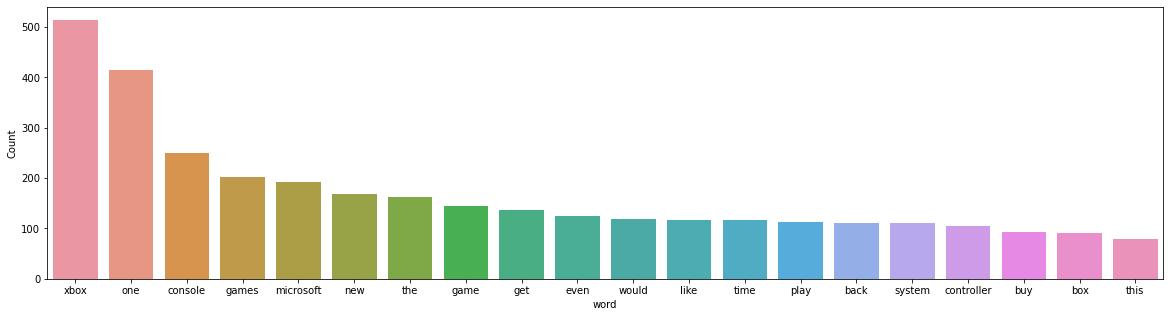

In [167]:
freq_words(reviews, 20)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting closer to be used for the model.<br>The next step is to lemmatize the data.

Here, the reviews are tokenized:

In [168]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['hope', 'never', 'sell']


Below, the reviews are lemmatized:

In [169]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[2]) 

['stock', 'replenish', 'game', 'compatible', 'feed', 'troll']


The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [170]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

xboxonex_negative['reviews'] = reviews_3

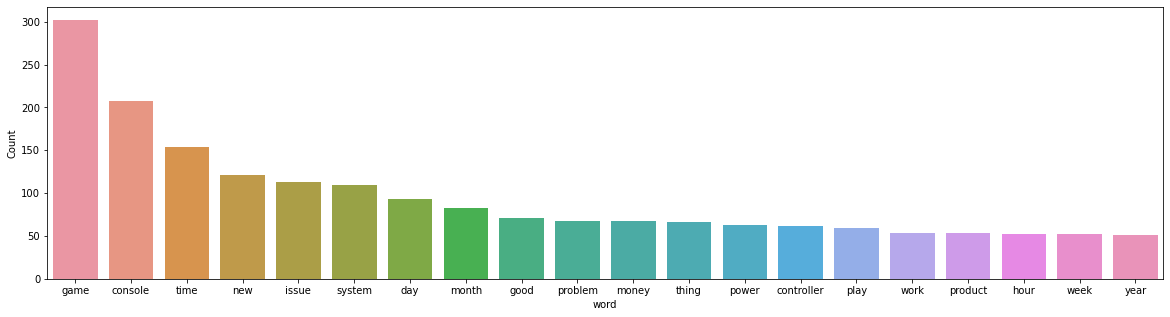

In [171]:
freq_words(xboxonex_negative['reviews'], 20)

As can be seen, the tokens are now cleaner as words such as "game", "system", and "hour" are now clearly showing in the dataset.<br>The dataset is now ready for model building.

#                                              LDA Model (Xbox One X Negative Reviews)

The code below is run in order to incorporate the reviews into a dictionary in order to set up the LDA Model.

In [172]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.<br>
The number of topics I chose through trial and error were 4.

In [173]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 4,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Here, this code is being run to print the topics and the words associated with it:

In [174]:
lda_model.print_topics()

[(0,
  '0.030*"game" + 0.017*"day" + 0.017*"time" + 0.012*"problem" + 0.012*"week" + 0.010*"console" + 0.010*"work" + 0.010*"error" + 0.010*"issue" + 0.009*"thing"'),
 (1,
  '0.039*"game" + 0.021*"console" + 0.020*"time" + 0.018*"new" + 0.017*"system" + 0.013*"issue" + 0.012*"good" + 0.009*"old" + 0.008*"bad" + 0.007*"controller"'),
 (2,
  '0.014*"issue" + 0.011*"game" + 0.011*"system" + 0.010*"time" + 0.010*"hour" + 0.010*"disk" + 0.009*"box" + 0.007*"internet" + 0.007*"new" + 0.007*"pass"'),
 (3,
  '0.037*"console" + 0.023*"month" + 0.018*"game" + 0.014*"product" + 0.013*"year" + 0.012*"problem" + 0.011*"new" + 0.011*"money" + 0.010*"warranty" + 0.010*"day"')]

This code is run to visualize the LDA model into a graphical bubble plot:

In [175]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.013922  0.087765       1        1  38.520202
3     -0.078806  0.003421       2        1  30.189829
0     -0.026488 -0.084846       3        1  24.308058
2      0.119216 -0.006341       4        1   6.981911, topic_info=           Term        Freq       Total Category  logprob  loglift
24        month   93.000000   93.000000  Default  30.0000  30.0000
49      console  210.000000  210.000000  Default  29.0000  29.0000
99         hour   43.000000   43.000000  Default  28.0000  28.0000
21        issue  104.000000  104.000000  Default  27.0000  27.0000
221      system  104.000000  104.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
76     purchase    2.655573   23.866137   Topic4  -5.5278   0.4660
706  connection    2.380537   14.469110   Topic4  -5.6371   0.8572
24        month    3.204187   93.547153   Topic4  -5.3400  -0.7122
85        drive    2.570439   23.811484   Topic4  -5.5604   0.4358
97        money    2.692835   67.532181   Topic4  -5.5138  -0.5602

[310 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
108       3  0.908592     amazon
526       1  0.924650      angry
1666      4  0.491136    apology
1667      4  0.706252   apparent
561       4  0.706252     appear
...     ...       ...        ...
69        2  0.694087      worth
189       2  0.957866  worthless
57        1  0.245244       year
57        2  0.665663       year
57        3  0.105105       year

[498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

As can be seen above, there are 4 topics which are clearly separated.<br>Based on the words within each topic, I can take a reasonable guess as to what the topics are about:<br>                                    

Topic 1: Possible issues with the price of the product: issue, price, bad, product<br>
Topic 2: Possible issues with the warranty and customer service: problem, warranty, customer, service<br>
Topic 3: Topic is on product defects: error, issue, factory, product, reset<br>
Topic 4: Possible issues with scammers for the product as well as calls for replacements: disc, box, internet, scam, replacement<br>

Based on the topics, it looks like there were more issues with Xbox One X than the Playstation 4 by comparison.<br>
The price of the system seemed to be an issue.<br>It also seems there were possible issues with customer support as customers were calling to replace their Xbox One X.<br>Also, the issues pertain as well to the product defects as there are reviews were people needed to reset their machines.


#                                        Data Splitting: Xbox One X Reviews

Here, the Xbox One X reviews are split into the positive set with ratings >= 4:

In [176]:
positive =  xboxseriesxreviews['stars'] >= 4
xboxseriesxreviews_positive = xboxseriesxreviews[positive]
xboxseriesxreviews_positive.head(5)

,stars,comment
5,5,Your browser does not support HTML5 video....
6,5,Do you actually need this review? No...
7,4,"So, yeah, new generation of hardware..."
8,5,As soon as I opened the package I wa...
9,5,"Really great product, a few bugs whe..."


In [177]:
xboxseriesxreviews_positive.shape

(448, 2)

There are 448 reviews with 3 columns in the dataset.

Below the Xbox One X reviews are split into negative set with ratings <= 3:

In [178]:
negative =  xboxseriesxreviews['stars'] <= 3
xboxseriesxreviews_negative = xboxseriesxreviews[negative]
xboxseriesxreviews_negative.head(5)

,stars,comment
0,1,This isn't because there aren't many...
1,1,Console powered down the first day. ...
2,1,Well got it on launch day. Suffered ...
3,1,"Defective at launch, love it lots.:("
4,3,Honestly the same as the Xbox one ju...


In [179]:
xboxseriesxreviews_negative.shape

(115, 2)

There are 115 reviews with 3 columns in the dataset.

#                         Data Cleaning (Xbox Series X Positive Reviews)

The following section is done in order to prepare the Xbox Series X positive reviews for the LDA model.
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.
Visualizations will also be built in order to take a better look at the data.

Here is a frequency bar graph of the positive reviews:

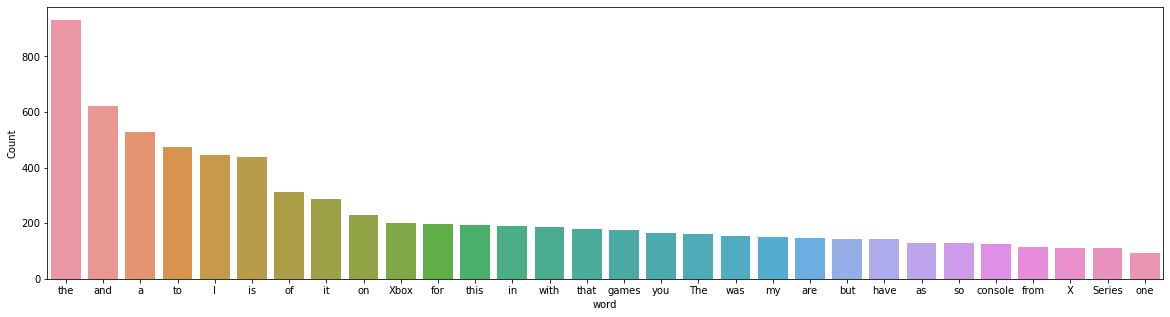

In [180]:
freq_words(xboxseriesxreviews_positive['comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br>But these are not necessary words because these words don't show true sentiment.<br>The dataset will need to be cleaned further in order to prepare this dataset for the model.

This code removes the characters and samples from the text dataset:

In [181]:
xboxseriesxreviews_positive['comment'] = xboxseriesxreviews_positive['comment'].str.replace("[^a-zA-Z#]"," ")

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [182]:
xboxseriesxreviews_positive['comment'] = xboxseriesxreviews_positive['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

The following removes the stopwords from the text:

In [183]:
reviews = [remove_stopwords(r.split()) for r in xboxseriesxreviews_positive['comment']]

The folowing turns the reviews lowercase:

In [184]:
reviews = [r.lower() for r in reviews]

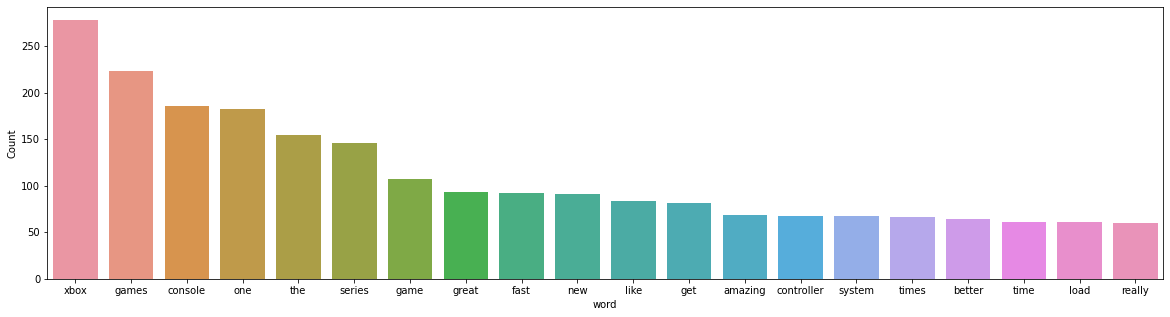

In [185]:
freq_words(reviews, 20)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting close to being used for the model.<br>The next step is to lemmatize the data.

Below, the reviews are tokenized:

In [186]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['actually', 'need', 'review', 'you', 'know', 'buying', 'idk', 'even', 'scrolled', 'reading', 'the', 'console', 'still', 'stock', 'teasing', 'looking', 'listingor', 'back', 'stock', 'reading', 'review', 'goes', 'back', 'stock', 'good', 'job', 'wasting', 'time']


Below, the reviews are lemmatized:

In [187]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) 

['review', 'console', 'teasing', 'listingor', 'stock', 'reading', 'review', 'stock', 'good', 'job', 'time']


The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [188]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

xboxseriesxreviews_positive['reviews'] = reviews_3

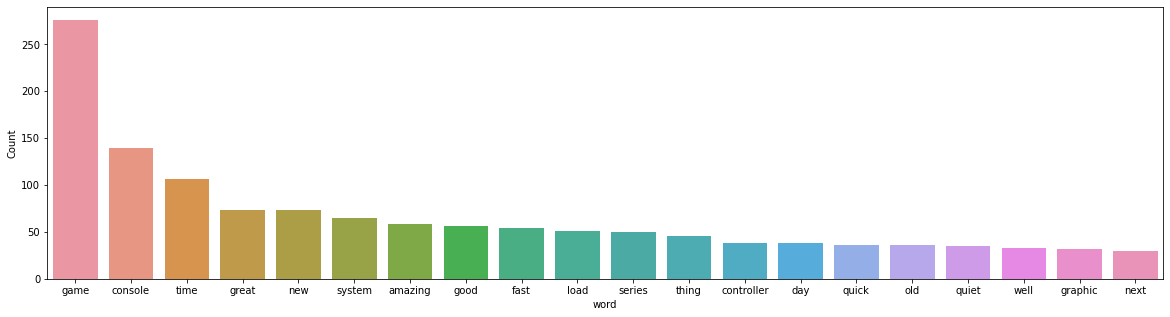

In [189]:
freq_words(xboxseriesxreviews_positive['reviews'], 20)

As can be seen, the tokens are now cleaner as words such as "game", "system", and "hour" are now clearly showing in the dataset.<br>The dataset is now ready for model building.

#                                        LDA Model (Xbox Series X Positive Reviews)

The code below is run in order to incorporate the reviews into a dictionary in order to set up the LDA Model.

In [190]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.<br>
The number of topics chosen through trial and error were 3.

In [191]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 3,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Here, this code is being run to print the topics and the words associated with it:

In [192]:
lda_model.print_topics()

[(0,
  '0.052*"game" + 0.032*"time" + 0.024*"console" + 0.023*"amazing" + 0.021*"good" + 0.019*"fast" + 0.017*"load" + 0.013*"next" + 0.013*"system" + 0.012*"thing"'),
 (1,
  '0.023*"game" + 0.022*"console" + 0.018*"day" + 0.018*"new" + 0.011*"series" + 0.009*"experience" + 0.009*"old" + 0.007*"thing" + 0.007*"work" + 0.007*"title"'),
 (2,
  '0.048*"game" + 0.040*"great" + 0.031*"console" + 0.015*"new" + 0.013*"system" + 0.010*"controller" + 0.010*"love" + 0.009*"series" + 0.009*"ssd" + 0.009*"speed"')]

This code is run to visualize the LDA model into a graphical bubble plot:

In [193]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.095814  0.036374       1        1  46.676213
2     -0.010754 -0.088540       2        1  30.308409
1     -0.085060  0.052166       3        1  23.015377, topic_info=        Term       Freq       Total Category  logprob  loglift
76     great  96.000000   96.000000  Default  30.0000  30.0000
12      load  47.000000   47.000000  Default  29.0000  29.0000
67      fast  54.000000   54.000000  Default  28.0000  28.0000
57       day  44.000000   44.000000  Default  27.0000  27.0000
212      ssd  16.000000   16.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
144   system   8.179888   64.300180   Topic3  -5.0700  -0.5929
76     great   8.435206   96.742253   Topic3  -5.0392  -0.9706
24      time   7.296544  100.751954   Topic3  -5.1842  -1.1563
31      good   6.774104   71.962508   Topic3  -5.2585  -0.8940
1    amazing   6.162231   79.462890   Topic3  -5.3532  -1.0878

[227 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.437310     able
0         2  0.437310     able
0         3  0.097180     able
184       2  0.824206  account
1105      2  0.824202      air
...     ...       ...      ...
157       3  0.038648    worth
996       3  0.767454     xbox
158       1  0.522897     year
158       2  0.174299     year
158       3  0.261449     year

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

As can be seen above, there are 3 topics which are clearly separated.<br>Based on the words within each topic, I can take a reasonable guess as to what the topics are about:<br>         

Topic 1: Topic seems to be on how fast the system has become: amazing, fast, load, quick, new, powerful<br>
Topic 2: Topic on speed but also graphics of the system: Controller, ssd, speed, quiet, feature, launch, graphic<br>
Topic 3: Topic seems to be on the size of the Xbox: new, experience, old, system, big, box<br>

Generally, it seems that early reviews of the system are positive based on the speed of the new Xbox.<br>There were also 
some positie comments on the ssd, controller, and the graphics.<br>Finally, there were comments from the positive reviews
on the size of the Xbox Series X as well.

#                                 Data Cleaning (Xbox Series X Negative Reviews)

The following section is done in order to prepare the Xbox Series X negative reviews for the LDA model.<br>
The data will need to be split, tokenized, and lemmatized in order to prepare it for the model.<br>
Visualizations will also be built in order to take a better look at the data.<br>

Below is a frequency bar graph of the Xbox Series X negative reviews:

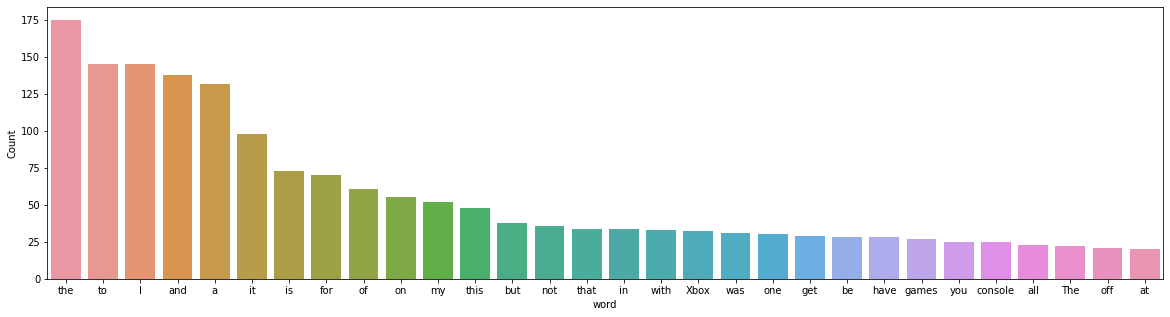

In [194]:
freq_words(xboxseriesxreviews_negative['comment'])

Looking above, it seems most of the most frequent words are "the", "and", and "for".<br>But these are not necessary words because these words don't show true sentiment.<br>The dataset will need to be cleaned further in order to prepare this dataset for the model.

This code removes the characters and samples from the text dataset:

In [195]:
xboxseriesxreviews_negative['comment'] = xboxseriesxreviews_negative['comment'].str.replace("[^a-zA-Z#]"," ")

The following code is run in order to remove short words (length < 3) to make the data cleaner:

In [196]:
xboxseriesxreviews_negative['comment'] = xboxseriesxreviews_negative['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

The following removes the stopwords from the text:

In [197]:
reviews = [remove_stopwords(r.split()) for r in xboxseriesxreviews_negative['comment']]

The following makes the text lowercase:

In [198]:
reviews = [r.lower() for r in reviews]

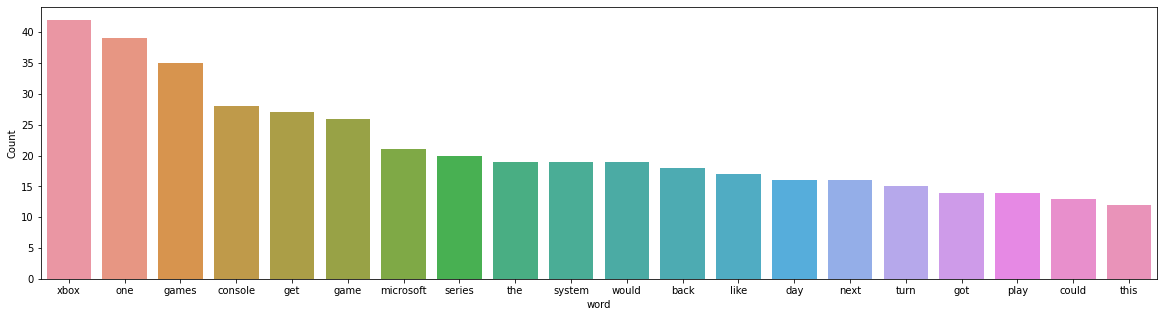

In [199]:
freq_words(reviews, 20)

Re-running a frequency bar graph on the data, it seems the stopwords have been removed and the reviews are getting close to being used for the model.<br>The next step is to lemmatize the data.

Below, the following code splits the text into tokens: 

In [200]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['console', 'powered', 'first', 'day', 'sending', 'back', 'xbox']


Below, the reviews is then lemmatized:

In [201]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) 

['first', 'day']


The following code is run in order to append the reviews to a new dataframe in order to show a frequency graph 
of the lemmatized reviews later on:

In [202]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

xboxseriesxreviews_negative['reviews'] = reviews_3

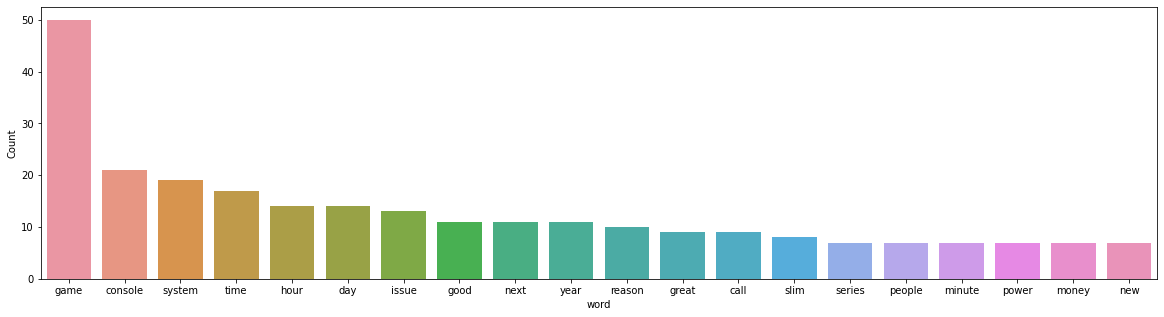

In [203]:
freq_words(xboxseriesxreviews_negative['reviews'], 20)

As can be seen, the tokens are now clearer as words such as "game", "system", and "hour" are now clearly showing in the dataset.<br>The dataset is now ready for model building.

#                                             LDA Model (Xbox Series X Negative Reviews)

The code below is run in order to incorporate the reviews into a dictionary in order to set up the LDA Model.


In [204]:
dictionary = corpora.Dictionary(reviews_2)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

Next, the LDA Model is imported and the next lines of code are run in order to build the model.
The number of topics chosen through trial and error were 5.

In [205]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus = doc_term_matrix, 
                id2word = dictionary,
                num_topics = 5,
                random_state = 100,
                chunksize = 1000,
                passes = 50)

Below, this code is being run to print the topics and the words associated with it:

In [206]:
lda_model.print_topics()

[(0,
  '0.044*"console" + 0.023*"day" + 0.019*"power" + 0.019*"work" + 0.015*"shut" + 0.012*"fine" + 0.012*"series" + 0.012*"problem" + 0.012*"hour" + 0.012*"min"'),
 (1,
  '0.026*"game" + 0.018*"hour" + 0.018*"day" + 0.013*"people" + 0.013*"great" + 0.013*"first" + 0.013*"problem" + 0.009*"terrible" + 0.009*"expensive" + 0.009*"week"'),
 (2,
  '0.027*"call" + 0.023*"hour" + 0.020*"week" + 0.017*"service" + 0.014*"minute" + 0.014*"time" + 0.014*"request" + 0.014*"customer" + 0.014*"form" + 0.013*"issue"'),
 (3,
  '0.057*"game" + 0.031*"system" + 0.019*"console" + 0.018*"good" + 0.017*"time" + 0.015*"slim" + 0.015*"next" + 0.011*"year" + 0.011*"issue" + 0.011*"reason"'),
 (4,
  '0.041*"game" + 0.018*"year" + 0.018*"new" + 0.015*"people" + 0.015*"price" + 0.015*"money" + 0.015*"system" + 0.013*"issue" + 0.012*"time" + 0.009*"controller"')]

This code is run to visualize the LDA model into a graphical bubble plot:

In [207]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.126227 -0.086217       1        1  37.445433
4     -0.076450  0.113220       2        1  19.374923
2      0.124143 -0.002987       3        1  17.612890
0      0.053159 -0.044878       4        1  14.482899
1      0.025374  0.020862       5        1  11.083855, topic_info=        Term       Freq      Total Category  logprob  loglift
64   console  20.000000  20.000000  Default  30.0000  30.0000
123     call   6.000000   6.000000  Default  29.0000  29.0000
8       hour   9.000000   9.000000  Default  28.0000  28.0000
55    system  17.000000  17.000000  Default  27.0000  27.0000
0       game  40.000000  40.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
196  control   0.658774   1.877438   Topic5  -5.2876   1.1524
268    sound   0.658695   1.877461   Topic5  -5.2877   1.1523
265  headset   0.658695   1.877461   Topic5  -5.2877   1.1523
186    order   0.658630   2.548592   Topic5  -5.2878   0.8465
230   supply   0.658488   1.877508   Topic5  -5.2880   1.1519

[289 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
117       1  0.355906  address
117       3  0.355906  address
249       4  0.778300   affect
118       3  0.749755    agent
75        2  0.752538   amount
...     ...       ...      ...
100       1  0.441192     year
100       2  0.352954     year
100       3  0.088238     year
100       4  0.088238     year
100       5  0.088238     year

[357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

As can be seen above, there are 5 topics which are clearly separated.<br>Based on the words within each topic, I can take a reasonable guess as to what the topics are about:<br>      

Topic 1: Topic may possibly be on the hdr: issue, hdr<br>
Topic 2: Topic could be on complaints of the price and battery: price, issue, time, battery<br>
Topic 3: Possible complaints on the support service: call, hour, week, service, replacement<br>
Topic 4: Topic is on replacing the Xbox: boot, disc, available, replacement<br>
Topic 5: Topic is possibly based on the price and issues with the system<br>

Based on the topics, it seems the negative reviews for the systems are similar to its predecessor.<br> There seems to be issues
with the hardware.<br>There are also issues with the price, time, and battery.<br>Furthermore, the support service for the Xbox
looks to continue to be an issue.<br>Already, customers are looking to replace their Xboxs.<br>This seems to correlate with reports of the Xbox overheating and breaking down as seen in news reports.



#                                              Summary/ Data Limitations


Based on the entire analysis, I can conclude the following:<br>

1. Comparing the PS4 negative reviews with the PS5 negative reviews, it seems Sony has fixed most of the problems with the PS5.<br> The PS4 had issues with the hard drive, warranty, and hardware of the product.<br> In comparison, most consumers complained more about obtaining the PS5 rather than the actual product itelf.<br> This difference reveals that Sony seems to have little to no issues with the new PS5 from a product standpoint compared to its predecessor which is very good from Sony's perspective.

2. Comparing the PS5 negative reviews with Xbox Series X negative reviews, the latter seems to have product issues as there were reviews pointing out the system dying and customers actually reaching out to customer support for refunds.<br> There were also issues with the price and battery.<br>Based on this analysis, it doesn't seem that Microsoft fully checked their new system for defects as much as Sony did.<br>This reveals that Microsoft needs to do a more thorough job in identifying these type of defects.<br>Sony seems to have done a great job, for the most part, in reducing the number of defects within the PS5.

3. Comparing the PS5 positive reviews vs the Xbox Series X positive reviews, both seemed to be similar in their respective LDA topic models.<br>Both systems seem to be praised for their controller, hardware, and speed. Words such as "amazing" and "graphics" were part of both LDA models.<br>It seems both systems seem to have satisfied consumer's expectations based on the positive reviews.

4. Comparing the PS4 positive reviews vs the Xbox One X positive reviews, consumers seems to be really satisifed.<br>The models both showed comments on the controller, design, and speed for both systems.<br>Both systems seem to have improved similarly.<br>The PS4 and Xbox One x positive reviews follow the same pattern as the PS5 and Xbox Series X in terms of positive reviews.

5. Comparing the Xbox Series X negative reviews with the Xbox Series X negative reviews, both systems seem to have issues with customer service as well as product defects.<br>There were comments made towards consumers asking for replacements and refunds due to defects.<br>This is in sharp contrast to the Playstation reviews as there little to no comments made in terms of consumers asking for a refund.


Data limitations need to be recognized though.<br>There was not a lot of data to analyze as only about 6,000 or more reviews overall were analyzed for this sentiment analysis.<br>The PS5 and Xbox Series X are both fairly new so it was difficult to get a good sample size for these reviews.<br>In contrast, PS4 and Xbox One X reviews were plentiful considering both products have been around for some time.<br>


Nevetherless, this analysis shows the different sentiments and comments towards how consumers feel towards the PS4, Xbox One X, PS5, and Xbox Series X.<br>Readers should be able to see this analysis and both Playstation and Microsoft can benefit from this analysis in terms of improving customer experiences and looking for areas of growth and opportunity for their respective game consoles.